In [26]:
"""
Written By: Rajeev Jain for TAS&C Magazine, 2025-09-13 

Following is a python implementation of the "Points and Line Chart" (aka P&L) 
as introduced by Mohamed Ashraf in this issue’s articles. Three python functions
are provided to implement the P&L calculations and to generate the P&L Chart. The 
plotting function is designed to highlight the P&L price reversals (aka swing points).
When enabled the date of the reversal will be overlayed on the associated volume bar 
and the number of days of the reversal move will be overlayed on the associated number
of days bar.

Two usage examples are provided:
1) Using sample data (from article) to verify the P&L calculations.
2) P&L Chart for ETF ticker `GLD` from 2024 to present

The Trader Tip article will include example #2 while a Jupyter Notebook will contain both example #1 & #2.

Example Jupyter Notebook can be downloaded from github repository:

Contact Rajeev Jain, jainraje@yahoo.com


"""

# import required python libraries
%matplotlib inline

import yfinance as yf
import pandas as pd
import numpy as np
import math
import datetime as dt
import matplotlib.pyplot as plt
from matplotlib.patches import Patch

print(yf.__version__)

0.2.58


In [37]:
def calc_point_size(price):
    """
    This function determines the point size based on provided price value.

    Parameters:
    price (float): price value.

    Returns:
    (float): point size matching look up table in article.
    """
    
    if 0 <= price <= 0.25:
        return 0.025
    elif 0.25 < price <= 1:
        return 0.05
    elif 1 < price <= 5:
        return 0.25
    elif 5 < price <= 20:
        return 0.50
    elif 20 < price <= 100:
        return 1
    elif 100 < price <= 200:
        return 2
    elif 200 < price <= 500:
        return 5
    elif 500 < price <= 1000:
        return 10
    elif 1000 < price <= 2000:
        return 20
    elif 2000 < price <= 5000:
        return 50
    elif 5000 < price <= 10000:
        return 100
    elif 10000 < price <= 20000:
        return 200
    else:
        return np.nan


def calc_point_and_line(data, reshape=True):
    """
    This function performs all the P&L calculations.

    Parameters:
    data (dataframe): dataframe must contain at minium the following 
    4 columns named: 'Date', 'Close', 'Volume', 'Symbol'.

    Returns:
    (dataframe): dataframe with 'P&L Close', 'Total Volume', 'Number of Days'
    """
    
    df = data.reset_index().copy()
    reversal_size = 3
    
    # make sure the column exists
    df["Plot"] = ""
    df["Total Volume"] = np.nan
    df["Direction"] = 0
    
    for i in range(len(df)):
        value = df.iloc[i]['Close']
        volume = df.iloc[i]['Volume']
        point_size = calc_point_size(value)
    
        if i == 0:
            last_level = value
            last_index = i
            df.at[df.index[i], 'Plot'] = "Yes"
            direction = 0
            volume_total = volume
            num_days = 1
    
        else:
            if direction == 1:            
                if (value >= last_level + point_size) or (value <= last_level - reversal_size*point_size):
                    if value <= last_level - reversal_size*point_size:               
                        direction = -1

                    df.at[df.index[last_index], "Total Volume"] = volume_total
                    df.at[df.index[last_index], "Number of Days"] = num_days
                    df.at[df.index[last_index], "Direction"] = direction
                    df.at[df.index[i], "Plot"] = "Yes"
                    last_level = value
                    last_index = i
                    volume_total = volume
                    num_days = 1
                    
                else:
                    volume_total += volume
                    num_days += 1
                                        
            elif direction == -1:
                if (value <= last_level - point_size) or (value >= last_level + reversal_size*point_size):
                    if value >= last_level + reversal_size*point_size:               
                        direction = 1
    
                    df.at[df.index[last_index], "Total Volume"] = volume_total
                    df.at[df.index[last_index], "Number of Days"] = num_days
                    df.at[df.index[last_index], "Direction"] = direction
                    df.at[df.index[i], "Plot"] = "Yes"
                    last_level = value
                    last_index = i
                    volume_total = volume
                    num_days = 1
                    
                else:
                    volume_total += volume
                    num_days += 1
                        
            else:  # direction == 0
                if (value >= last_level + point_size) or (value <= last_level - point_size):
                    direction = 1 if value >= last_level + point_size else -1
                        
                    df.at[df.index[last_index], "Total Volume"] = volume_total
                    df.at[df.index[last_index], "Number of Days"] = num_days
                    df.at[df.index[last_index], "Direction"] = direction
                    df.at[df.index[i], "Plot"] = "Yes"
                    last_level = value
                    last_index = i
                    volume_total = volume
                    num_days = 1
                    
                else:
                    volume_total += volume
                    num_days += 1
    
    # after the loop, finalize the last segment
    df.at[df.index[last_index], "Total Volume"] = volume_total
    df.at[df.index[last_index], "Number of Days"] = num_days
    df.at[df.index[last_index], "Direction"] = direction

    if reshape:
        cols = ['Close', 'Total Volume', 'Number of Days']
        cond = df['Plot']=='Yes'
        df = df[cond].reset_index(drop=True)

    df['Date'] = df['Date'].astype(str)
    
    cond_swing_high = (df['Close'].shift(2) < df['Close'].shift(1)) & (df['Close'].shift() > df['Close'])
    df['Swing High'] = np.where(cond_swing_high, df['Date'].shift(), '')

    cond_swing_low = (df['Close'].shift(2) > df['Close'].shift(1)) & (df['Close'].shift() < df['Close'])
    df['Swing Low'] = np.where(cond_swing_low, df['Date'].shift(), '')

    df['Swing High'] = df['Swing High'].shift(-1)
    df['Swing Low'] = df['Swing Low'].shift(-1)

    df.at[df.index[-1], "Swing High"] = ''
    df.at[df.index[-1], "Swing Low"] = ''
    
    
    return df



def plot_point_line_chart(df, display_sp=False, display_nd=False):
    """
    This function will plot the Point and Line Chart with 3 subplots:
    1) P&L Price
    2) Total Volume
    3) Number of Days

    Parameters:
    df (dataframe): dataframe containing the P&L calculations (ie output of the P&L calcilation routine) 
    display_sp (BOOL) : True or False toggle to enable/disable Swing Point date over-lay on swing point volume bars
    display_nd (BOOL): True or False toggle to enable/disable number of days over-lay on swing point day bars

    Returns:
    No return
    """

    bar_width = 0.25
    
    fig, axes = plt.subplots(3, 1, figsize=(10, 7), sharex=True, gridspec_kw={'height_ratios':[3,2,2]})
    
    # --- Overall Figure Title ---
    ticker = df.iloc[0]['Symbol']
    fig.suptitle(f"P&L Chart, Ticker={ticker}", fontsize=16, fontweight='bold', y=0.95)
    
    # --- Closing Prices ---
    axes[0].plot(df.index, df['Close'], marker='o', linestyle='-', color='blue', label='Close Price')
    axes[0].set_title("P&L of Closing Prices")
    axes[0].set_ylabel("Price")
    axes[0].legend(loc="upper left")
    axes[0].grid(True, which='major', linestyle='--', alpha=0.6)


    # --- Add note to upper-right of the price subplot title ---
    note_text = f"Last Close={df.iloc[-1]['Close'].round(2)}"
    axes[0].text(1.0, 1.02, note_text, transform=axes[0].transAxes,
                 ha='right', va='bottom', fontsize=10, fontweight='regular', color='black')
   
    # --- Volume colors based on Direction ---
    volume_colors = ['green' if d==1 else 'red' for d in df['Direction']]
    
    # --- Total Volume ---
    axes[1].bar(df.index, df['Total Volume'], color=volume_colors, alpha=0.6, width=bar_width)
    axes[1].set_title("Total Volume")
    axes[1].set_ylabel("Volume")
    axes[1].grid(True, which='major', linestyle='--', alpha=0.6)
    
    # --- Annotate Swing High and Swing Low above Volume bars ---
    if display_sp:
        for idx, row in df.iterrows():
            volume_top = row['Total Volume']
            if pd.notna(row['Swing High']):
                axes[1].text(idx, volume_top + volume_top*0.02, f"{row['Swing High']}", color='red', fontsize=9,
                             ha='center', va='bottom', fontweight='regular')
            if pd.notna(row['Swing Low']):
                axes[1].text(idx, volume_top + volume_top*0.02, f"{row['Swing Low']}", color='green', fontsize=9,
                             ha='center', va='bottom', fontweight='regular')
    
    # --- Add legend for Volume colors ---
    volume_legend = [Patch(facecolor='green', label='Volume Up (Up Trend)'),
                     Patch(facecolor='red', label='Volume Down (Down Trend)')]
    axes[1].legend(handles=volume_legend, loc='upper left')
    
    # --- Number of Days (track Volume colors) ---
    axes[2].bar(df.index, df['Number of Days'], color=volume_colors, width=bar_width, alpha=0.6, label='Number of Days')
    axes[2].set_title("Number of Days")
    axes[2].set_ylabel("Days")
    axes[2].set_xlabel("Index / Day")
    axes[2].legend(loc="upper left")
    axes[2].grid(True, which='major', linestyle='--', alpha=0.6)

    # --- Annotate Number of Days only where Swing High/Low exists ---
    for idx, row in df.iterrows():
        # Swing High case
        if pd.notna(row['Swing High']) and row['Swing High'] != '':
            axes[2].text(idx, row['Number of Days'] + 0.1,
                         f"{int(row['Number of Days'])}",
                         ha='center', va='bottom', fontsize=9,
                         fontweight='bold', color='red')
        # Swing Low case
        if pd.notna(row['Swing Low']) and row['Swing Low'] != '':
            axes[2].text(idx, row['Number of Days'] + 0.1,
                         f"{int(row['Number of Days'])}",
                         ha='center', va='bottom', fontsize=9,
                         fontweight='bold', color='green') 
            
    # --- Add legend for Number of Days colors ---
    volume_legend = [Patch(facecolor='green', label='Number of Days (Up Trend)'),
                     Patch(facecolor='red', label='Number of Days (Down Trend)')]
    axes[2].legend(handles=volume_legend, loc='upper left')

    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.show()


In [29]:
# Create sample data to test and verify calculations and plotting functions. The sample
# data matches the hypothetical example data in the article 

col1 = [22,22.25,22.75,22.50,23,24,24.25,24.50,25,27,27.5,28.01, 
        28.30,28.50,27.50,26.50,26,25,24.80,25.50,26,26.50,27,27.90,28.50]

col2 = [100000,250000,300000,400000,500000,300000,150000,200000,
        300000,300000,500000,150000,200000,150000,90000,65000,
        50000,300000,500000,400000,300000,250000,300000,400000,500000]

df = pd.DataFrame({
    "Close": col1,
    "Volume": col2
})
df['Symbol'] = 'Test'
df.index.name = 'Date'
df.index = (df.index + 1)
data = df.copy()
data

,Close,Volume,Symbol
Date,,,
1,22.00,100000,Test
2,22.25,250000,Test
3,22.75,300000,Test
4,22.50,400000,Test
5,23.00,500000,Test
6,24.00,300000,Test
7,24.25,150000,Test
8,24.50,200000,Test
9,25.00,300000,Test


In [38]:
df = calc_point_and_line(data, reshape=True)
df

,Date,Close,Volume,Symbol,Plot,Total Volume,Direction,Number of Days,Swing High,Swing Low
0,1,22.00,100000,Test,Yes,1050000.0,1,4.0,,
1,5,23.00,500000,Test,Yes,500000.0,1,1.0,,
2,6,24.00,300000,Test,Yes,650000.0,1,3.0,,
3,9,25.00,300000,Test,Yes,300000.0,1,1.0,,
4,10,27.00,300000,Test,Yes,800000.0,1,2.0,,
5,12,28.01,150000,Test,Yes,705000.0,-1,6.0,12,
6,18,25.00,300000,Test,Yes,2450000.0,1,7.0,,18
7,25,28.50,500000,Test,Yes,500000.0,1,1.0,,


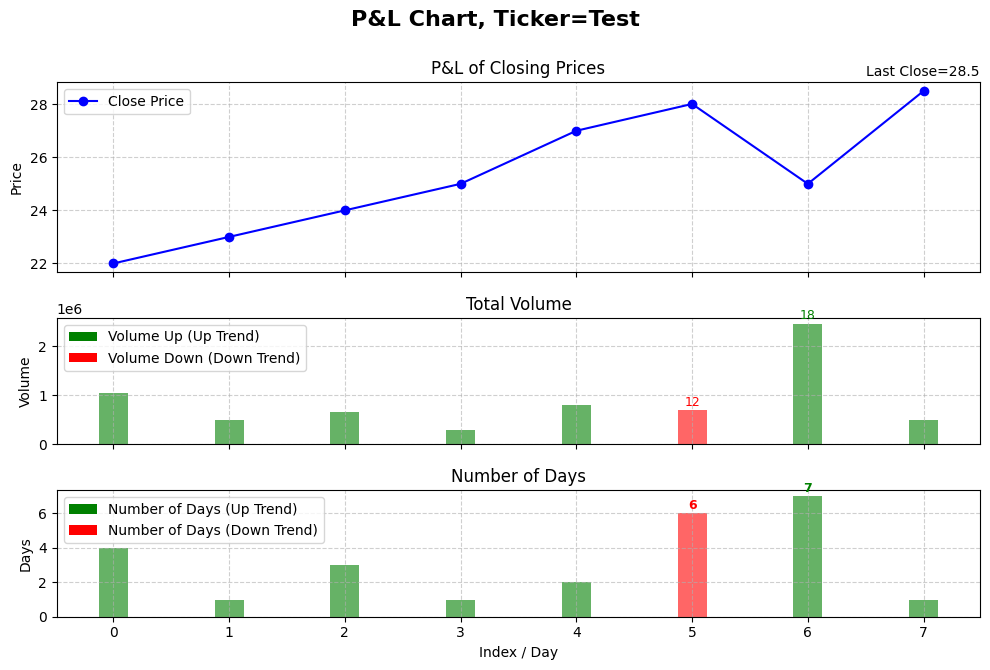

In [39]:
plot_point_line_chart(
    df, 
    display_sp=True, 
    display_nd=True
)

In [ ]:
ticker = 'ABBV'
ticker = 'VLO'
ticker = 'GLD'
ticker = 'RTX'

ticker = 'AMLP'
ticker = 'FBCG'

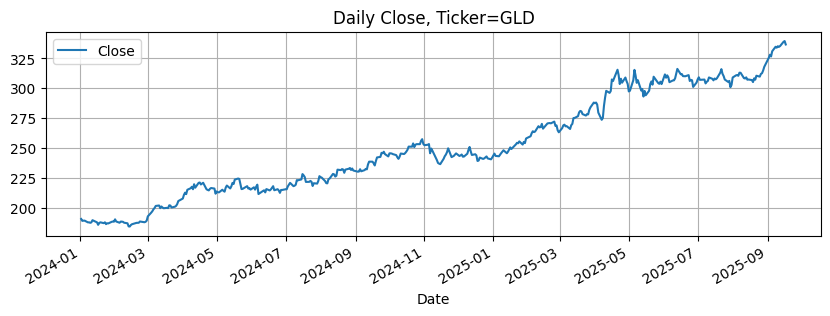

In [35]:
# Use Yahoo Finance python package to obtain OHLCV data for desired ticker

#ticker = '^GSPC'
ticker = 'GLD'

ohlcv = yf.download(
    ticker, 
    start="2019-01-01", 
    end="2025-09-18", 
    #group_by="Ticker", 
    auto_adjust=True,
    multi_level_index=False,
    progress=False,
)
ohlcv['Symbol']=ticker

# Simple line plot of daily close. Using slicing to plot desired start and end timeframe.
ax = ohlcv['2024':'2025'][['Close']].plot(figsize=(10, 3), grid=True, title=f'Daily Close, Ticker={ticker}')

In [40]:
ohlcv

,Close,High,Low,Open,Volume,Symbol
Date,,,,,,
2019-01-02,121.330002,121.750000,120.879997,121.349998,12776200,GLD
2019-01-03,122.430000,122.459999,121.730003,121.779999,15440800,GLD
2019-01-04,121.440002,121.599998,120.690002,121.320000,13334000,GLD
2019-01-07,121.860001,122.220001,121.570000,122.160004,7473600,GLD
2019-01-08,121.529999,121.709999,121.059998,121.150002,7643100,GLD
...,...,...,...,...,...,...
2025-09-11,334.760010,335.160004,332.970001,333.369995,9082600,GLD
2025-09-12,335.420013,336.390015,335.230011,335.880005,9619700,GLD
2025-09-15,338.910004,339.279999,336.230011,336.309998,10569900,GLD


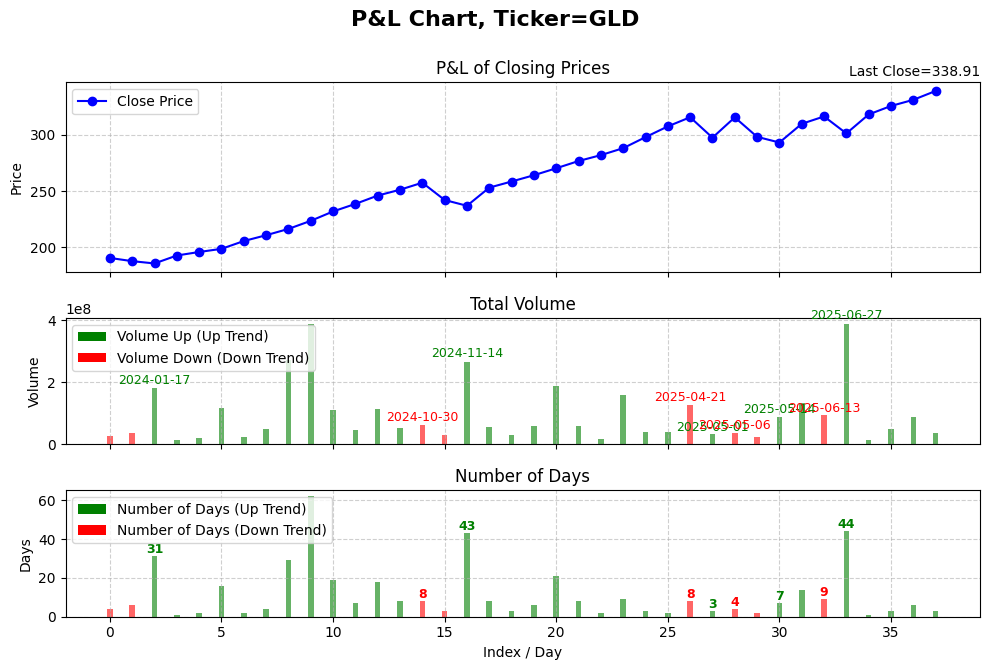

In [41]:
# execute P&L calculations and plot the P&L Chart. Using slicing to plot desired start and end timeframe.
df = calc_point_and_line(ohlcv['2024':'2025'].reset_index(), reshape=True)
plot_point_line_chart(
    df, 
    display_sp=True, 
    display_nd=True
)

In [23]:
df

,index,Date,Close,High,Low,Open,Volume,Symbol,Plot,Total Volume,Direction,Number of Days,Swing High,Swing Low
0,0,2020-06-05,20.398840,20.458748,20.159206,20.368885,99500,FBCG,Yes,340000.0,-1,4.0,,
1,4,2020-06-11,19.769798,20.548609,19.742841,20.468731,114700,FBCG,Yes,2599100.0,1,26.0,,2020-06-11
2,30,2020-07-20,22.825136,22.855089,22.142179,22.535578,83800,FBCG,Yes,2284200.0,1,21.0,,
3,51,2020-08-18,23.993351,24.043274,23.713777,23.963396,108500,FBCG,Yes,834300.0,1,6.0,,
4,57,2020-08-26,25.361259,25.361259,24.896969,25.051733,289800,FBCG,Yes,8371800.0,1,51.0,,
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
75,1271,2025-06-27,48.040001,48.080002,47.500000,47.790001,656600,FBCG,Yes,4457700.0,1,12.0,,
76,1283,2025-07-16,49.090000,49.160000,48.500000,49.080002,311700,FBCG,Yes,2392700.0,1,8.0,,
77,1291,2025-07-28,50.279999,50.314999,50.070000,50.279999,348900,FBCG,Yes,6326400.0,1,11.0,,
78,1302,2025-08-12,51.669998,51.724998,50.970001,51.299999,518000,FBCG,Yes,9435600.0,1,23.0,,
